# Clustering


In [1]:
import json
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pylab as plt
import networkx.algorithms.community as communnity


from collections import Counter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from networkx.algorithms import bipartite
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# note, fa2 might not be up to date with newest package versions of networkx or scipy.
from fa2 import ForceAtlas2


%matplotlib inline

## Prepare graph

In [209]:
fgraph_C = pd.read_csv('fgraph_C.txt', sep=" ", header=None)
fgraph_C = fgraph_C.drop_duplicates()
display(fgraph_C)

0                  1
0                  a20.c   compiler_types.h
1                  a20.c          linkage.h
2                  a20.c           export.h
3                  a20.c         compiler.h
4                  a20.c            types.h
...                  ...                ...
2743601  irqbypass.mod.c  error-injection.h
2743606  irqbypass.mod.c       utsrelease.h
2743607  irqbypass.mod.c       build-salt.h
2743608  irqbypass.mod.c          elfnote.h
2743609  irqbypass.mod.c         vermagic.h

[1884314 rows x 2 columns]

In [210]:
print("The number of relationships of type .c->.h is ",Counter(fgraph_C[0].str.contains("\.c") & fgraph_C[1].str.contains("\.h"))[True])
print("The number of relationships of type .h->.h is ",Counter(fgraph_C[0].str.contains("\.h") & fgraph_C[1].str.contains("\.h"))[True])
print("The number of relationships of type .c->.c is ",Counter(fgraph_C[0].str.contains("\.c") & fgraph_C[1].str.contains("\.c"))[True])
print("The number of relationships of type .h->.c is ",Counter(fgraph_C[0].str.contains("\.h") & fgraph_C[1].str.contains("\.c"))[True])

The number of relationships of type .c->.h is  1884257
The number of relationships of type .h->.h is  3
The number of relationships of type .c->.c is  53
The number of relationships of type .h->.c is  0


In [6]:
# remove hh and cc connections
hh_index = fgraph_C[fgraph_C[0].str.contains("\.h") & fgraph_C[1].str.contains("\.h")].index
cc_index = fgraph_C[fgraph_C[0].str.contains("\.c") & fgraph_C[1].str.contains("\.c")].index
fgraph_C = fgraph_C.drop(hh_index)
fgraph_C = fgraph_C.drop(cc_index)

In [7]:
print("The number of relationships of type .c->.h is ",Counter(fgraph_C[0].str.contains("\.c") & fgraph_C[1].str.contains("\.h"))[True])
print("The number of relationships of type .h->.h is ",Counter(fgraph_C[0].str.contains("\.h") & fgraph_C[1].str.contains("\.h"))[True])
print("The number of relationships of type .c->.c is ",Counter(fgraph_C[0].str.contains("\.c") & fgraph_C[1].str.contains("\.c"))[True])
print("The number of relationships of type .h->.c is ",Counter(fgraph_C[0].str.contains("\.h") & fgraph_C[1].str.contains("\.c"))[True])

The number of relationships of type .c->.h is  1884257
The number of relationships of type .h->.h is  0
The number of relationships of type .c->.c is  0
The number of relationships of type .h->.c is  0


In [8]:
# create graph in networkx
compile_graph = nx.Graph() 
compile_graph.add_nodes_from(list(set(fgraph_C[0])), bipartite=0)
compile_graph.add_nodes_from(list(set(fgraph_C[1])), bipartite=1)
compile_graph.add_edges_from(list(fgraph_C.itertuples(index=False, name=None)))

In [9]:
# devide bipartite node sets and project onto the h nodes
top_nodes = {n for n, d in compile_graph.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(compile_graph) - top_nodes

h_graph = bipartite.projected_graph(compile_graph, bottom_nodes)

In [11]:
nodes, edges = h_graph.order(), h_graph.size()
avg_deg = float(edges)/nodes
print("Nodes: ", nodes)
print("Edges: ", edges)
print("Average degree: ", avg_deg)
print("CC: ", len(list(nx.connected_components(h_graph))))

Nodes:  3396
Edges:  1592394
Average degree:  468.9028268551237
CC:  2


## Plot graph

In [16]:
# use forceatlas layout from gephi
fa2 = ForceAtlas2(outboundAttractionDistribution=True)
pos_fa2 = fa2.forceatlas2_networkx_layout(h_graph, pos=None, iterations=2000)

100%|██████████| 2000/2000 [02:44<00:00, 12.16it/s]

BarnesHut Approximation  took  90.33  seconds
Repulsion forces  took  34.14  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  37.14  seconds
AdjustSpeedAndApplyForces step  took  1.17  seconds


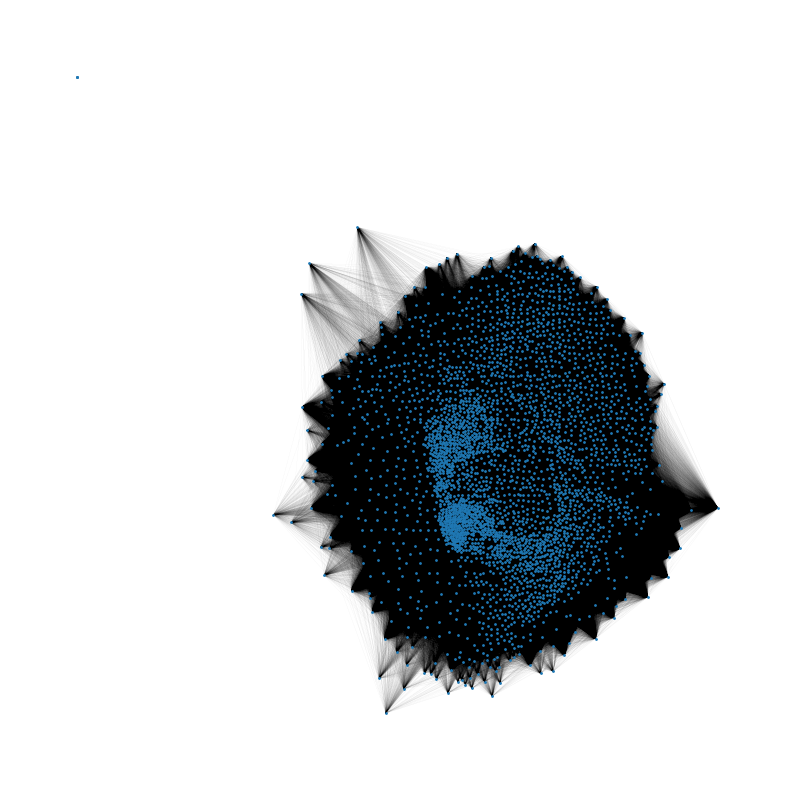

In [17]:
plt.figure(figsize=(10, 10))
plt.axis("off")
nx.draw(h_graph, pos_fa2, node_size=1, width=0.01)

plt.show()

## Clustering
In the following we try different clustering algorithms.

### Aglomarative Clustering

We use the similarity matrix know from the Ravasz algorithm.

$\text{sim}(u, v) = \frac{|N(u) \cap N(v)| + A_{u, v}}{\text{min}(deg(u), deg(v)) + 1 - A_{u, v}}$


In [19]:
def neighbourhood_sim(col_1, col_2, connected):
    d1 = sum(col_1)
    d2 = sum(col_2)
    
    overlap = sum((col_1==col_2) & (col_1==1))

    sim = (overlap + connected)/(min([d1, d2]) + 1 - connected)
    
    return sim

def similarity_matrix(A):
    sim_mat = np.zeros(A.shape)
    for i, col_i in enumerate(A):
        for j in range(i):
            col_j = A[j, :]
            con = col_i[j]
            sim_mat[i, j] = neighbourhood_sim(col_i, col_j, con)
            sim_mat[j, i] = sim_mat[i, j]
    return sim_mat

In [20]:
A_h = nx.adjacency_matrix(h_graph).toarray().T

In [21]:
# calculating the similarity matrix takes 1 hour, better load from file if already calculated
# sim_mat = similarity_matrix(A_h)
sim_mat = np.genfromtxt("sim_mat.out")

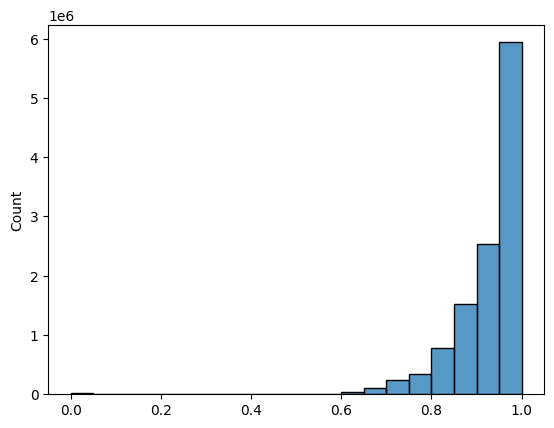

In [212]:
_ = sns.histplot(sim_mat.reshape(-1),  binwidth=0.05)
plt.show()

In [23]:
def plot_dendrogram(model, **kwargs):
    """ 
    Create linkage matrix and then plot the dendrogram, implementation from:
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    """
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
agg_clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric="precomputed", connectivity=A_h, linkage="average")

In [24]:
agg_clustering.fit(sim_mat)

/home/jan/ds/3rd-semester/LFN/lfn-venv/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:552: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


AgglomerativeClustering(connectivity=array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]]),
                        distance_threshold=0, linkage='average',
                        metric='precomputed', n_clusters=None)

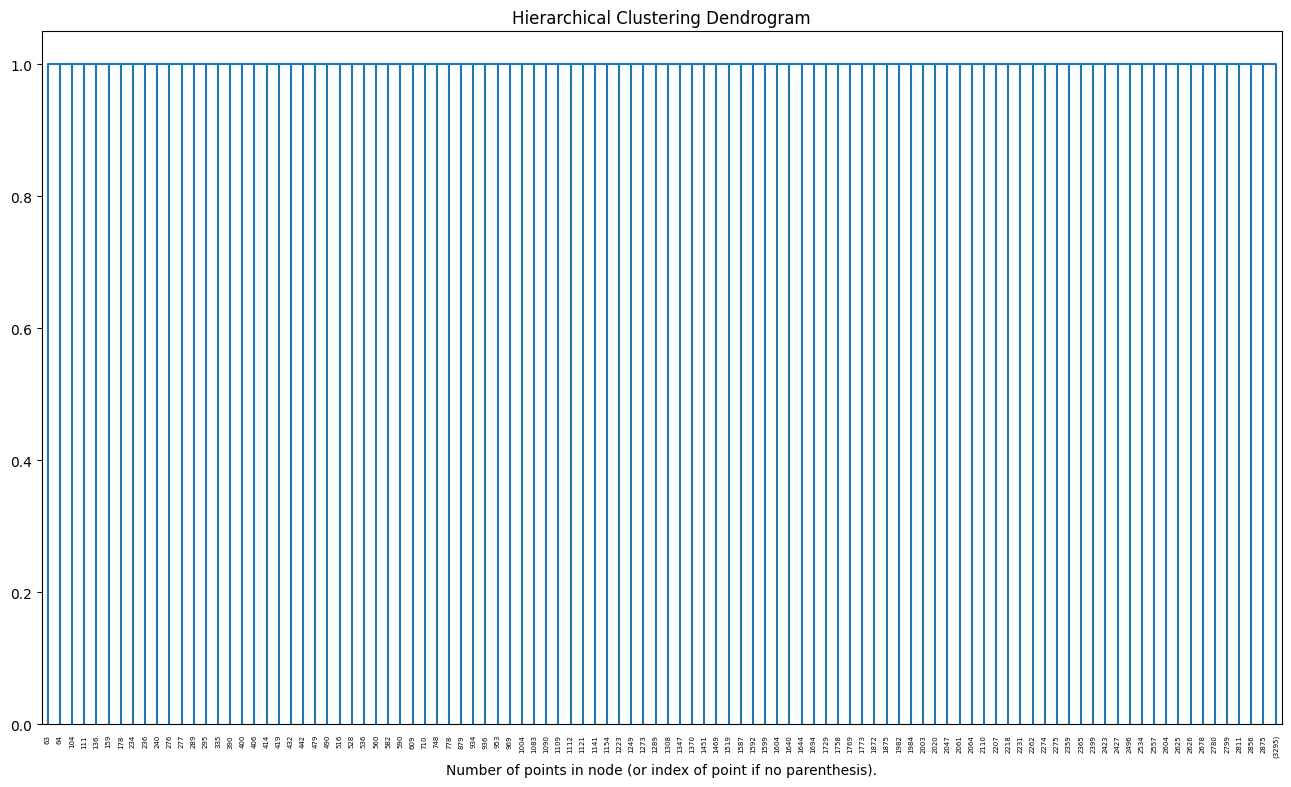

In [25]:
plt.figure(figsize=(16, 9))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_clustering, truncate_mode="level", p=100)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Find best Agglomarative clustering

In [26]:
# seperated largest cc
cc_h_graph = nx.connected_components(h_graph)
cc_h_graph_list = [c for c in cc_h_graph]

In [28]:
ids_second_component = []
for n in cc_h_graph_list[1]:
    for i, v in enumerate(h_graph.nodes):
        if n==v:
            print(n)
            print(f"index = {i}")
            print(f"degree = {h_graph.degree[n]}")
            ids_second_component.append(i)
ids_second_component.sort()

csmake-post-defs.h
index = 802
degree = 2
le_byteshift.h
index = 1592
degree = 2
csmake-pre-defs.h
index = 2495
degree = 2


In [29]:
# remove small connected component from similarity matrix
sim_mat_sub = np.delete(np.delete(sim_mat, ids_second_component, 0), ids_second_component, 1)


# create subgraph
A_h_sub = np.delete(np.delete(A_h, ids_second_component, 0), ids_second_component, 1)
h_graph_sub = h_graph.subgraph(cc_h_graph_list[0])


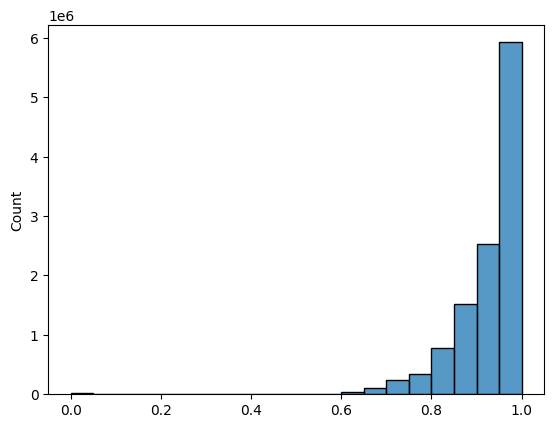

In [213]:
_ = sns.histplot(sim_mat_sub.reshape(-1),  binwidth=0.05)
plt.show()

In [31]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric="precomputed", connectivity=A_h_sub, linkage="average")
cl_ = model.fit_predict(sim_mat_sub)


cl_communities = [set() for i in np.unique(cl_)]    
for i, node in enumerate(h_graph_sub.nodes):
    idx = cl_[i]
    cl_communities[idx].add(node)

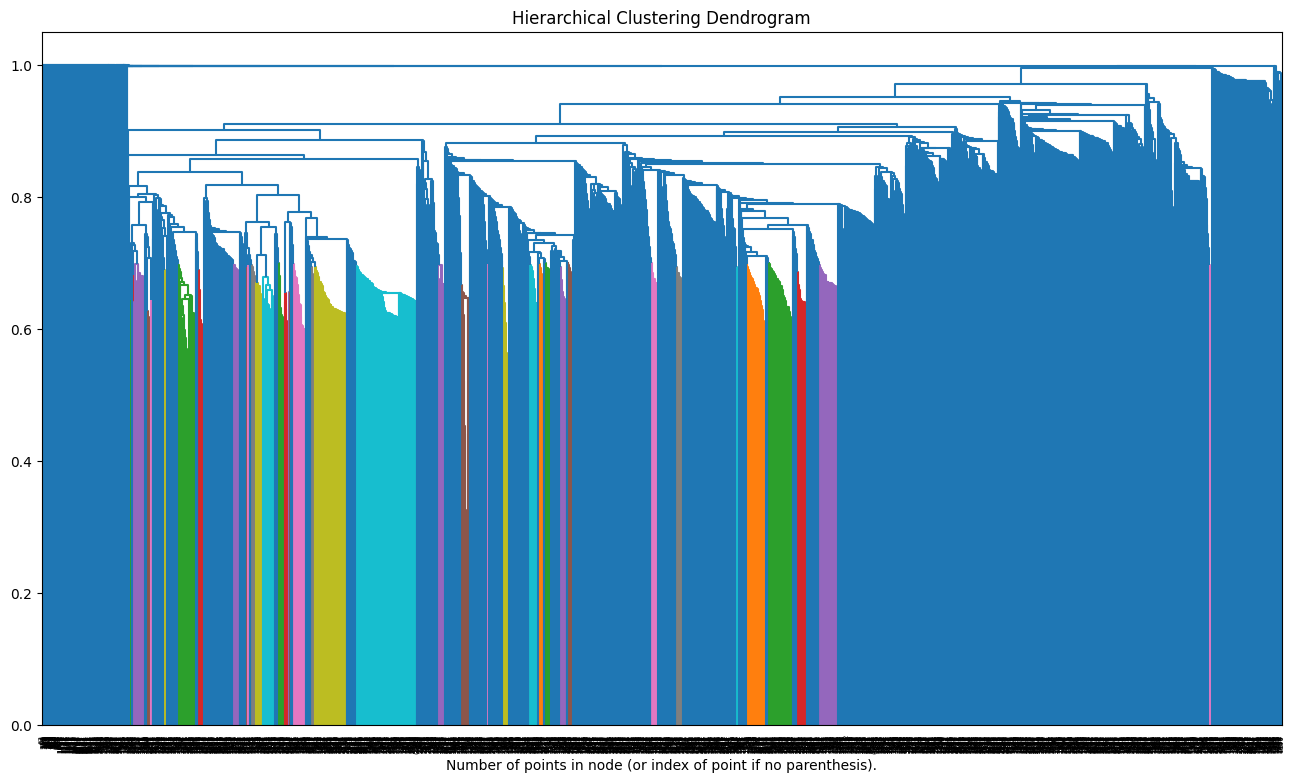

In [32]:
plt.figure(figsize=(16, 9))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=300)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

100%|██████████| 2000/2000 [02:43<00:00, 12.20it/s]


BarnesHut Approximation  took  83.80  seconds
Repulsion forces  took  35.70  seconds
Gravitational forces  took  0.28  seconds
Attraction forces  took  41.32  seconds
AdjustSpeedAndApplyForces step  took  1.33  seconds


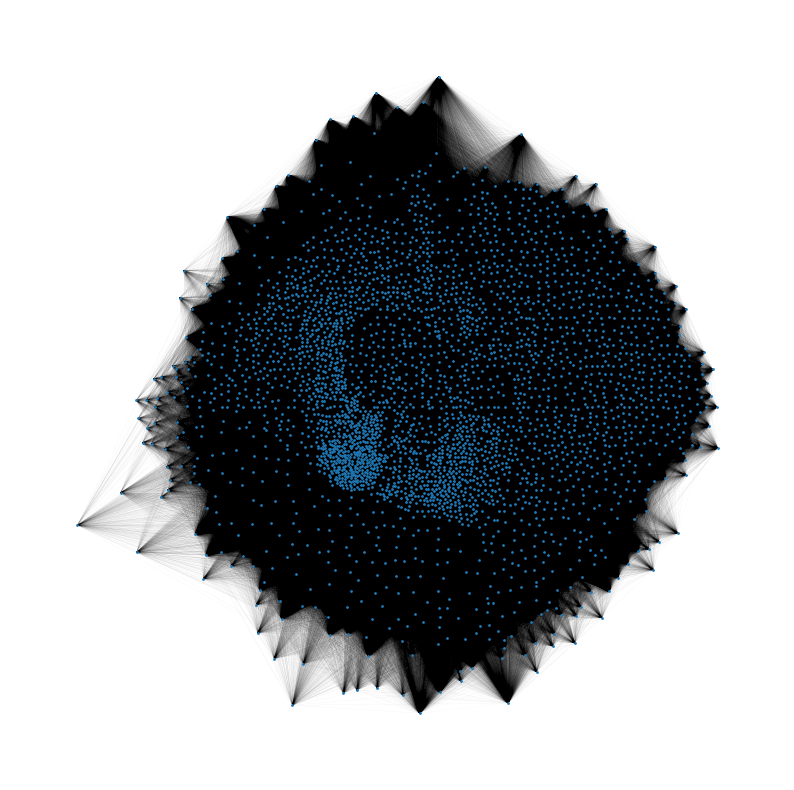

In [33]:
pos_fa2_sub = fa2.forceatlas2_networkx_layout(h_graph_sub, pos=None, iterations=2000)
plt.figure(figsize=(10, 10))
plt.axis("off")
nx.draw(h_graph_sub, pos_fa2_sub, node_size=1, width=0.01)

plt.show()

In [214]:
cv_clusters = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

cl_dic = {}
modularities = []

for n in cv_clusters:
    model = AgglomerativeClustering(n_clusters=n, metric="precomputed", connectivity=A_h_sub, linkage="average")
    cl_ = model.fit_predict(sim_mat_sub)

    cl_communities = [set() for i in np.unique(cl_)]    
    for i, node in enumerate(h_graph_sub.nodes):
        idx = cl_[i]
        cl_communities[idx].add(node)
    cl_dic[f"cl_{n}"] = cl_communities
    modularities.append(communnity.modularity(h_graph_sub, cl_communities))

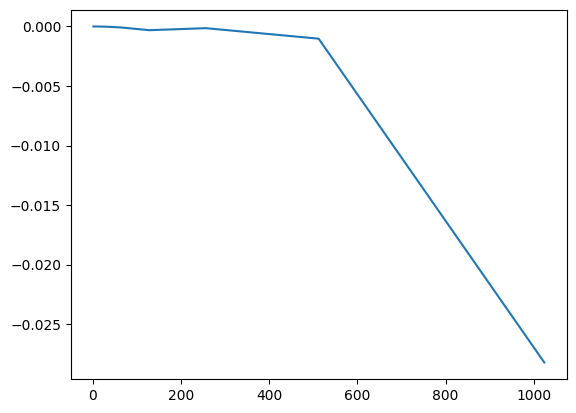

In [215]:
plt.plot(cv_clusters, modularities)
plt.show()

In [217]:
best_agg_modularity = np.max(modularities)
best_agg_clusters = cl_dic[f"cl_512"]

In [ ]:
# merge remaining clusters of size 1 into one rest cluster
best_agg_clusters_adjusted = []
minority_cluster = set()
for cl in best_agg_clusters:
    if len(cl)<2:
        minority_cluster.update(cl)
    else:
        best_agg_clusters_adjusted.append(cl)
    
best_agg_clusters_adjusted.append(minority_cluster)

In [ ]:
best_agg_colors = []
for node in h_graph_sub.nodes:
    for i, el in enumerate(best_agg_clusters_adjusted):
        if node in el:
            best_agg_colors.append(i)

In [ ]:
sizes = [len(c) for c in best_agg_clusters_adjusted]
print(sorted(sizes))

[2, 2, 2, 3, 3, 3, 4, 8, 17, 20, 50, 75, 76, 165, 496, 828, 1639]


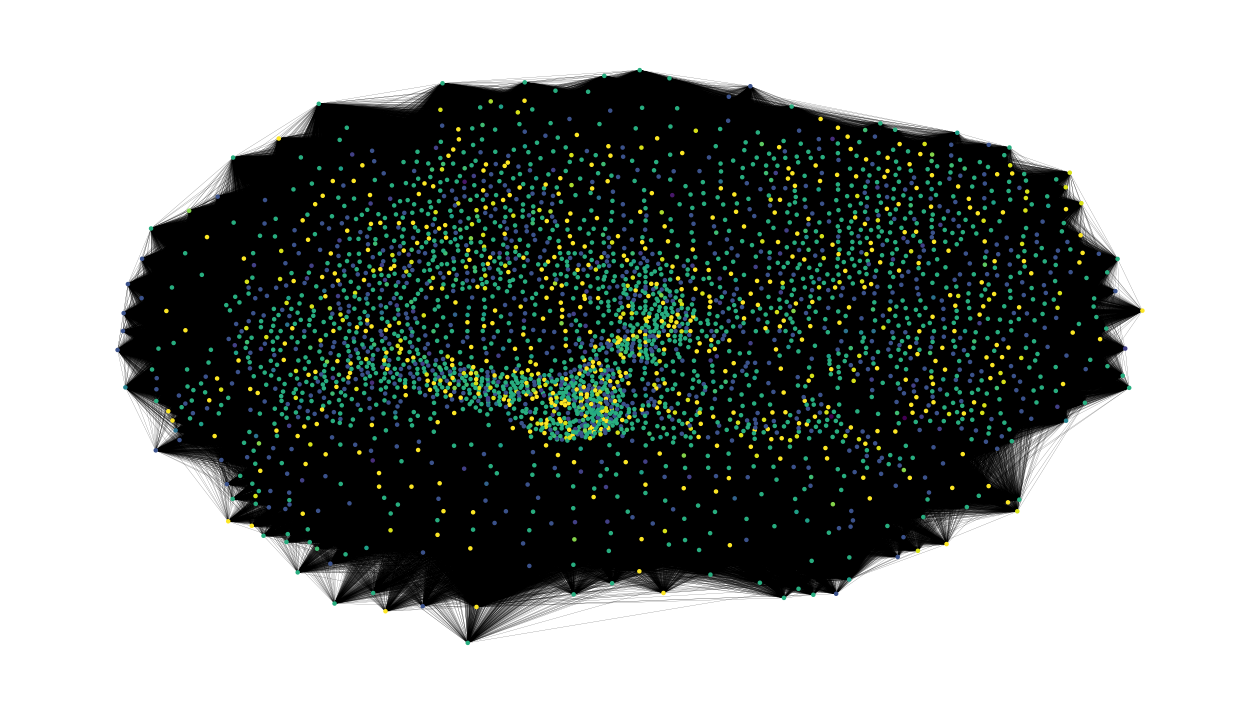

In [ ]:
plt.figure(figsize=(16, 9))
plt.axis("off")
nx.draw(h_graph_sub, pos_fa2_sub, node_size=5, width=0.1, node_color=best_agg_colors)

plt.show()

### Agg clustering with different similarity
For the first run of agglomarative clustering, 1 cluster maximized the modularity. One possibility to improve the algorithm could be considering another similarity function. We are gonna use the adjacency matrix. Idea behind that is that this way we put a lot of weight on direct connections and not on overlap of the neighborhoods. As the graph is very dense i.e. high overlap of neighborhoods this might allow for a more fine-grained picture.

In [ ]:
cv_clusters = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

cl_dic_adj = {}
modularities_adj = []

for n in cv_clusters:
    model = AgglomerativeClustering(n_clusters=n, metric="precomputed", connectivity=A_h_sub, linkage="average")
    cl_ = model.fit_predict(A_h_sub)

    cl_communities = [set() for i in np.unique(cl_)]    
    for i, node in enumerate(h_graph_sub.nodes):
        idx = cl_[i]
        cl_communities[idx].add(node)
    cl_dic_adj[f"cl_{n}"] = cl_communities
    modularities_adj.append(communnity.modularity(h_graph_sub, cl_communities))

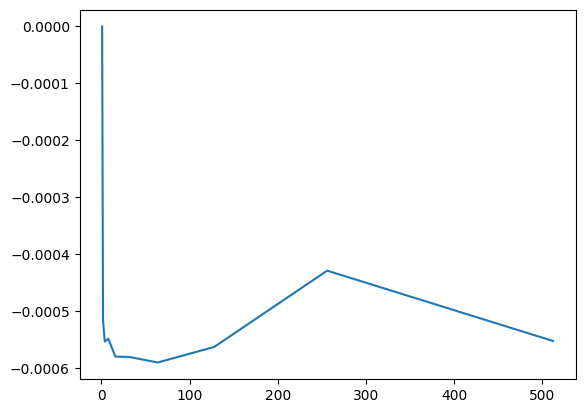

In [ ]:
plt.plot(cv_clusters, modularities_adj)

In [ ]:
best_agg_clusters = cl_dic_adj["cl_256"]
best_agg_clusters_adjusted = []
minority_cluster = set()
for cl in best_agg_clusters:
    if len(cl)<2:
        minority_cluster.update(cl)
    else:
        best_agg_clusters_adjusted.append(cl)
    
best_agg_clusters_adjusted.append(minority_cluster)

In [ ]:
sizes = [len(c) for c in best_agg_clusters_adjusted]
print(sorted(sizes))

[253, 1043, 1046, 1051]


In [ ]:
best_agg_colors = []
for node in h_graph_sub.nodes:
    for i, el in enumerate(best_agg_clusters_adjusted):
        if node in el:
            best_agg_colors.append(i)

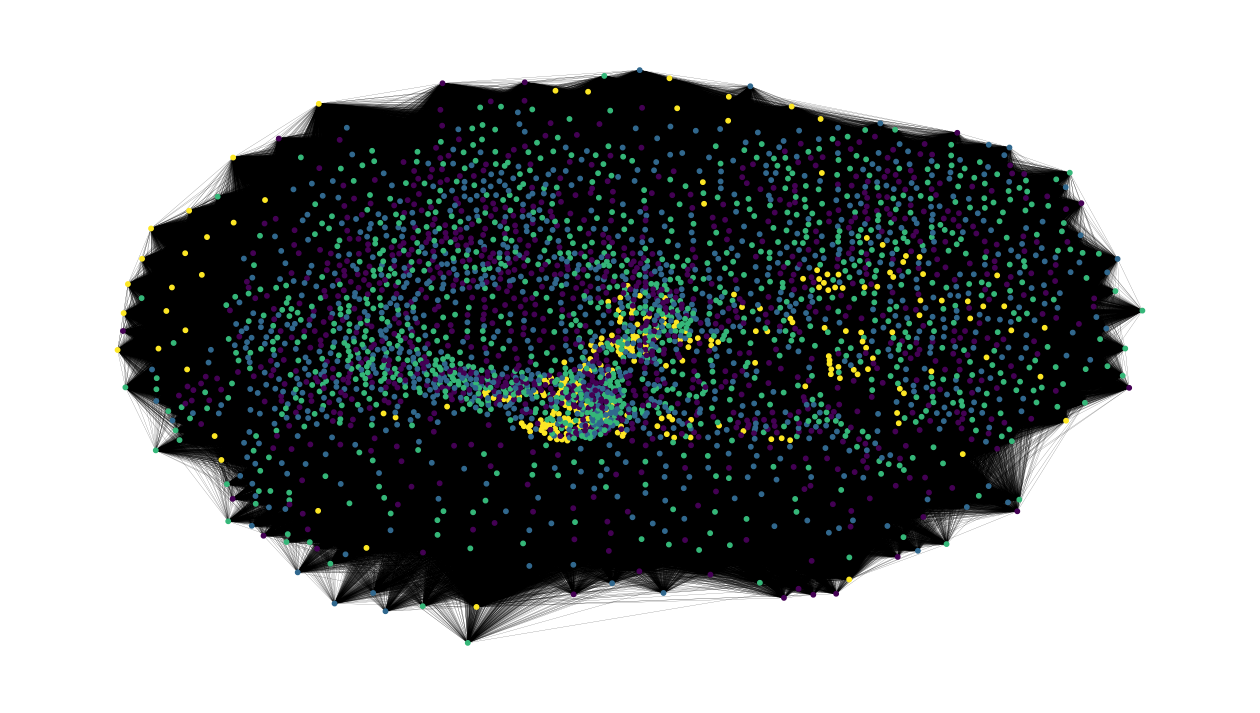

In [ ]:
plt.figure(figsize=(16, 9))
plt.axis("off")
nx.draw(h_graph_sub, pos_fa2_sub, node_size=10, width=0.1, node_color=best_agg_colors)

plt.show()

### greedy_modularity_communities

In [35]:
mod_clusters = communnity.greedy_modularity_communities(h_graph_sub)
mod_clusters_modularity = communnity.modularity(h_graph_sub, mod_clusters)

In [39]:
val_map = {}
for i, cluster in enumerate(mod_clusters):
    for node in cluster:
        val_map[node] = i

In [36]:
sizes_mod_clusters = [len(cl) for cl in mod_clusters]
print(sizes_mod_clusters)

[2225, 1108, 45, 15]


In [37]:
mod_colors = []
for node in h_graph_sub.nodes:
    for i, el in enumerate(mod_clusters):
        if node in el:
            mod_colors.append(i)

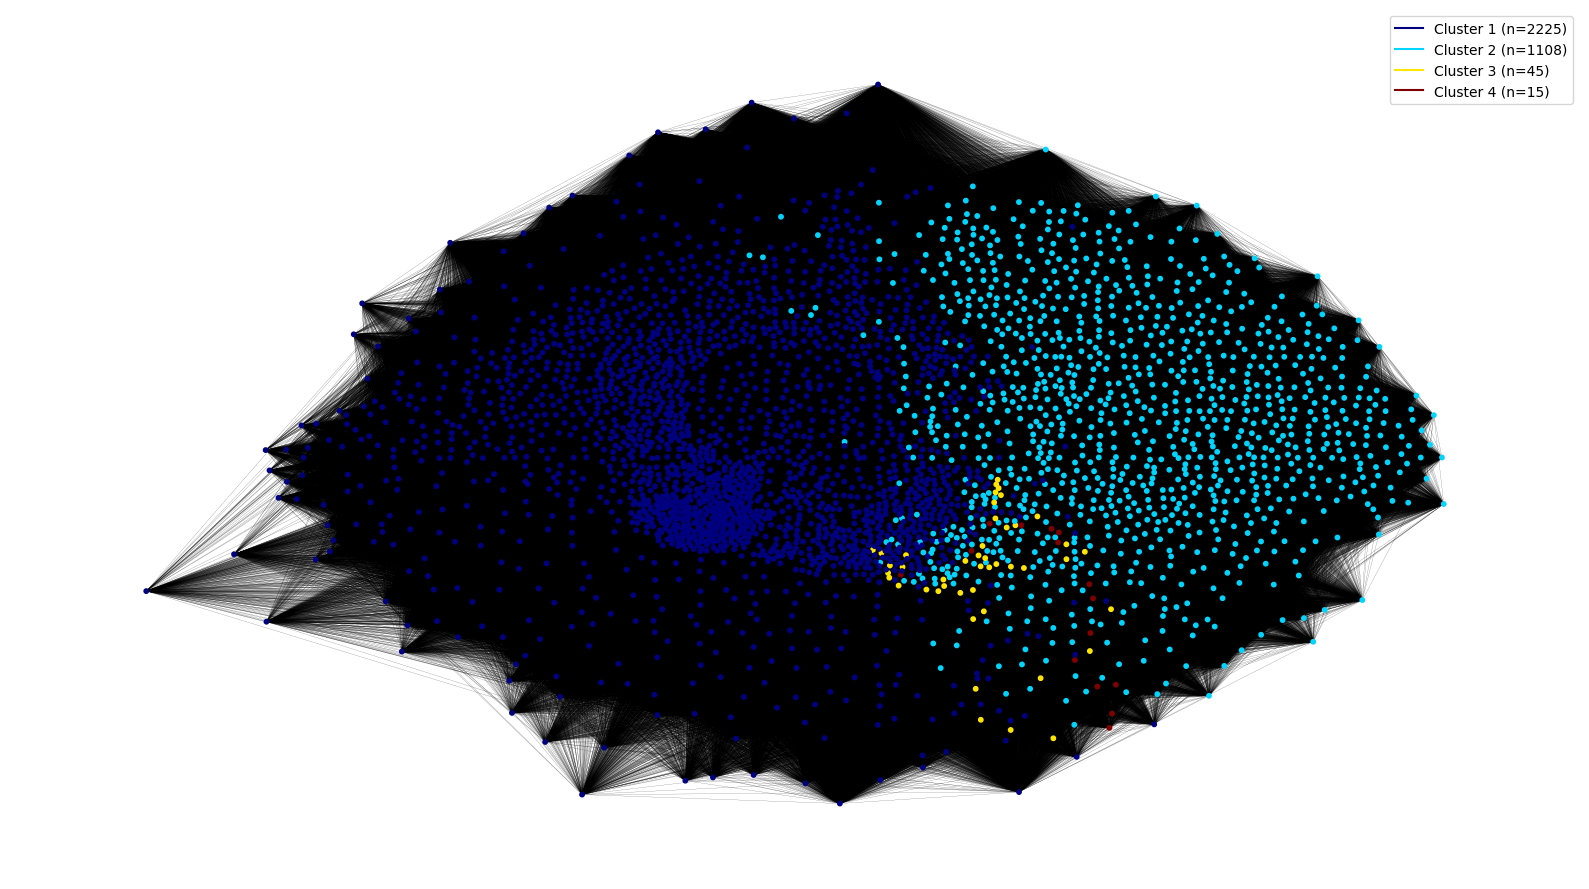

In [202]:
color_legend = {f"Cluster {i+1} (n={len(cluster)})":i for i, cluster in enumerate(mod_clusters)}
color_map_jet = plt.get_cmap('jet')
color_norm  = Normalize(vmin=0, vmax=max(mod_colors))
scalarMap = ScalarMappable(norm=color_norm, cmap=color_map_jet)


fig, ax = plt.subplots(figsize=(16, 9))

for label, value in color_legend.items():
    ax.plot([0],[0],color=scalarMap.to_rgba(value),label=label)

nx.draw(h_graph_sub, pos_fa2_sub, node_size=10, width=0.1, node_color=mod_colors, cmap=color_map_jet, ax=ax)
fig.set_facecolor('w')
fig.tight_layout()

plt.axis("off")
plt.legend()
plt.show()

In [54]:
# with open('mod_clusters.json', 'w') as file:
#     json.dump(val_map, file)

# Modularity evaluation

In [218]:
print(f"Best modularity by Agglomarative clustering: \t{best_agg_modularity}")
print(f"Best modularity by Modularity clustering: \t{mod_clusters_modularity}")

Best modularity by Agglomarative clustering: 	0.0
Best modularity by Modularity clustering: 	0.1184838375115864


In [50]:
for com in mod_clusters:
    print(len(com))

2225
1108
45
15


In [96]:
mod_clusters[3]

frozenset({'bnx2x.h',
           'bnx2x_cmn.h',
           'bnx2x_dcb.h',
           'bnx2x_fw_defs.h',
           'bnx2x_fw_file_hdr.h',
           'bnx2x_hsi.h',
           'bnx2x_init.h',
           'bnx2x_init_ops.h',
           'bnx2x_link.h',
           'bnx2x_reg.h',
           'bnx2x_sp.h',
           'bnx2x_sriov.h',
           'bnx2x_stats.h',
           'bnx2x_vfpf.h',
           'crc32c.h'})

In [98]:
mod_clusters[2]

frozenset({'be.h',
           'be_cmds.h',
           'be_hw.h',
           'be_iscsi.h',
           'be_main.h',
           'be_mgmt.h',
           'be_roce.h',
           'bnx2fc_constants.h',
           'bnx2x_mfw_req.h',
           'cnic_if.h',
           'cq_desc.h',
           'cq_enet_desc.h',
           'dca.h',
           'fc_els.h',
           'fc_encaps.h',
           'fc_fcp.h',
           'fc_frame.h',
           'fc_fs.h',
           'fc_gs.h',
           'fc_ms.h',
           'fc_ns.h',
           'fcoe_sysfs.h',
           'ixgbe.h',
           'ixgbe_common.h',
           'ixgbe_dcb.h',
           'ixgbe_fcoe.h',
           'ixgbe_ipsec.h',
           'ixgbe_mbx.h',
           'ixgbe_type.h',
           'libfc.h',
           'libfcoe.h',
           'rq_enet_desc.h',
           'scsi_netlink.h',
           'scsi_transport.h',
           'scsi_transport_fc.h',
           'vnic_cq.h',
           'vnic_dev.h',
           'vnic_devcmd.h',
           'vnic_intr.h',
         

### Compare with k-means

In [139]:
with open("deep_walk_clusters.json") as file:
    json_string = json.load(file)
    deep_walk_value_map = json.loads(json_string.replace("'", '"'))

In [186]:
deep_walk_clusters = [set() for i in range(6)]
for node, cluster in deep_walk_value_map.items():
    if node in cc_h_graph_list[1]:
        continue
    deep_walk_clusters[cluster].add(node)

In [156]:
deep_walk_colors = []
for node in h_graph_sub.nodes:
    cluster = deep_walk_value_map[node]
    deep_walk_colors.append(cluster)
    

In [187]:
deep_walk_modularity = communnity.modularity(h_graph_sub, deep_walk_clusters)

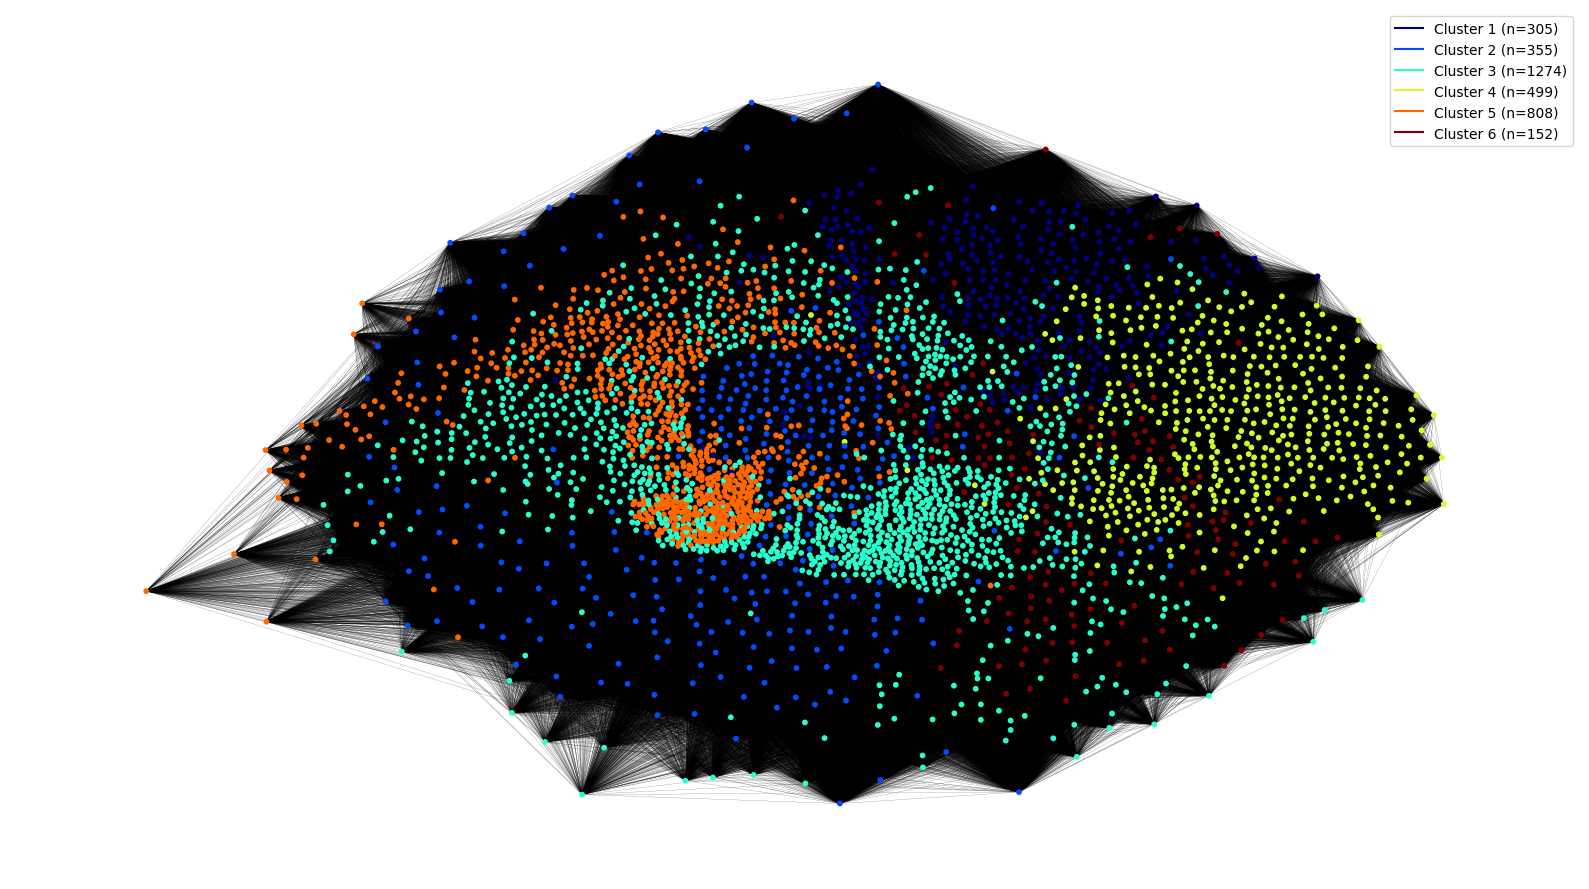

In [200]:
deep_walk_color_legend = {f"Cluster {i+1} (n={len(cluster)})":i for i, cluster in enumerate(deep_walk_clusters)}
color_map_jet = plt.get_cmap('jet')
color_norm  = Normalize(vmin=0, vmax=max(deep_walk_colors))
scalarMap = ScalarMappable(norm=color_norm, cmap=color_map_jet)


fig, ax = plt.subplots(figsize=(16, 9))

for label, value in color_legend.items():
    ax.plot([0],[0],color=scalarMap.to_rgba(value),label=label)

nx.draw(h_graph_sub, pos_fa2_sub, node_size=10, width=0.1, node_color=deep_walk_colors, cmap=color_map_jet, ax=ax)
fig.set_facecolor('w')
fig.tight_layout()

plt.axis("off")
plt.legend()
plt.show()

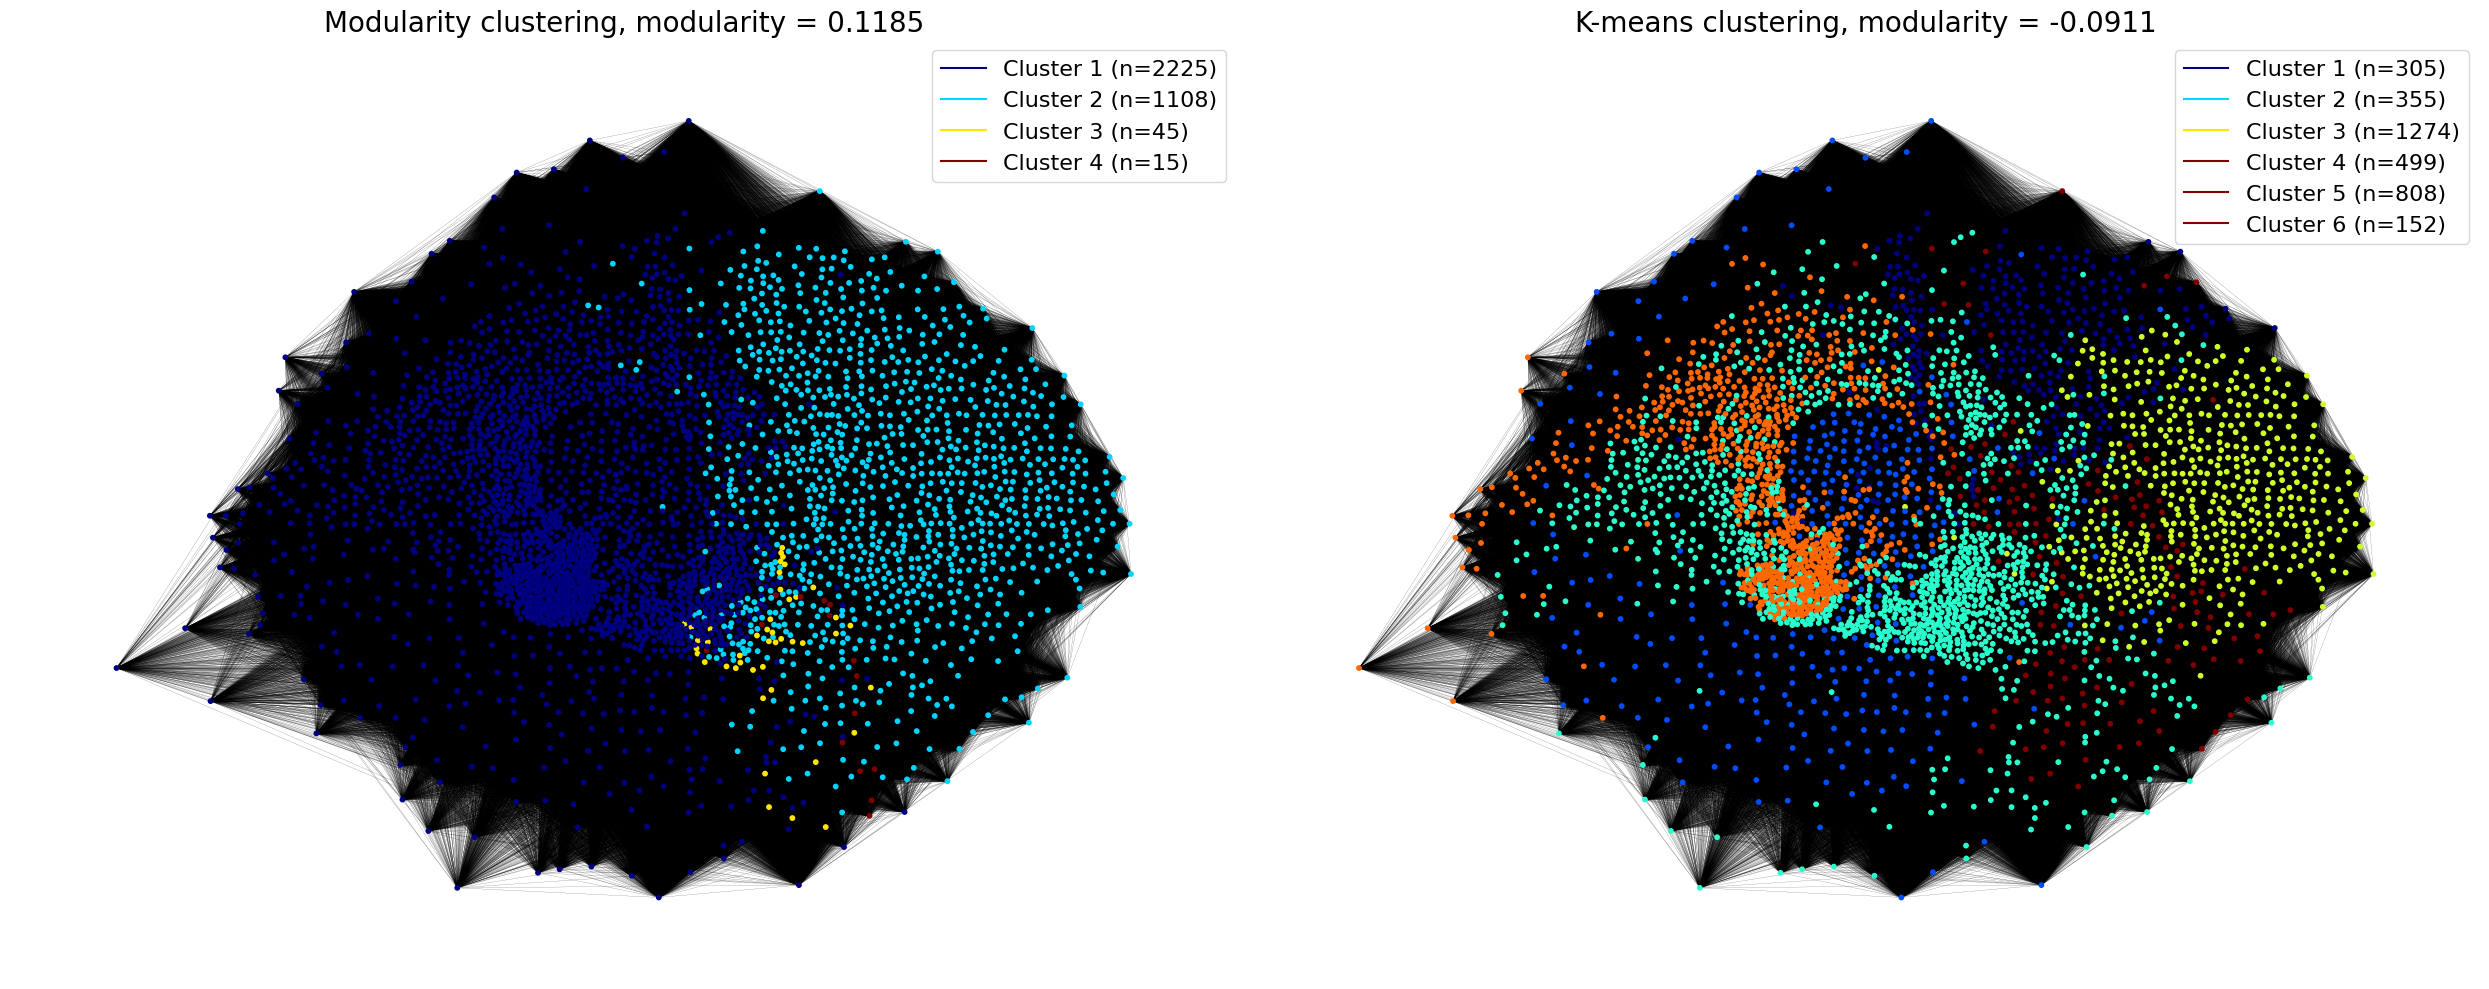

In [208]:
color_map_jet = plt.get_cmap('jet')

deep_walk_color_legend = {f"Cluster {i+1} (n={len(cluster)})":i for i, cluster in enumerate(deep_walk_clusters)}
deep_walk_color_norm  = Normalize(vmin=0, vmax=max(deep_walk_colors))
deep_walk_scalarMap = ScalarMappable(norm=color_norm, cmap=color_map_jet)

modularity_clustering_color_legend = {f"Cluster {i+1} (n={len(cluster)})":i for i, cluster in enumerate(mod_clusters)}
modularity_clustering_color_norm  = Normalize(vmin=0, vmax=max(mod_colors))
modularity_clustering_scalarMap = ScalarMappable(norm=color_norm, cmap=color_map_jet)



fig, axes = plt.subplots(ncols=2, figsize=(25, 10))

for label, value in modularity_clustering_color_legend.items():
    axes[0].plot([0],[0],color=modularity_clustering_scalarMap.to_rgba(value),label=label)


for label, value in deep_walk_color_legend.items():
    axes[1].plot([0],[0],color=deep_walk_scalarMap.to_rgba(value),label=label)

nx.draw(h_graph_sub, pos_fa2_sub, node_size=10, width=0.1, node_color=mod_colors, cmap=color_map_jet, ax=axes[0])
nx.draw(h_graph_sub, pos_fa2_sub, node_size=10, width=0.1, node_color=deep_walk_colors, cmap=color_map_jet, ax=axes[1])

axes[0].set_title(f"Modularity clustering, modularity = {np.round(mod_clusters_modularity, 4)}", fontsize=20)
axes[0].legend(fontsize=16)
axes[1].set_title(f"K-means clustering, modularity = {np.round(deep_walk_modularity, 4)}", fontsize=20)
axes[1].legend(fontsize=16)

fig.set_facecolor('w')
fig.tight_layout()

plt.axis("off")
plt.show()